<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/harry_potter/Harry_Potter_Karate_Club_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas neo4j scikit-learn karateclub

In [16]:
import networkx as nx
import pandas as pd
from neo4j import GraphDatabase
# Change the host and user/password combination to your neo4j
host = 'bolt://3.239.224.171:7687'
user = 'neo4j'
password = 'rainbow-mittens-track'
driver = GraphDatabase.driver(host,auth=(user, password))

def read_query(query, params=None):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [3]:
# import data
read_query("""
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/HP/hp_1.csv" as row
MERGE (s:Character{name:row.source})
MERGE (t:Character{name:row.target})
MERGE (s)-[r:INTERACTS]-(t)
SET r.weight = row.weight
RETURN distinct 'import successful' as result
""")

,result
0,import successful


In [4]:
# KarateClub only works on nodes with consecutive ids -> Preprocessing
read_query("""
MATCH (c:Character)
WITH count(*) as number, collect(c) as nodes
UNWIND range(0, number - 1) as index
WITH nodes[index] as node, index
SET node.index = index
RETURN distinct 'done' as result
""")

,result
0,done


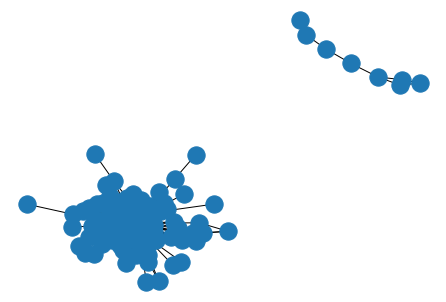

In [5]:
# Construct a networkX graph
edge_list = read_query("""
MATCH (s:Character)-[r:INTERACTS]->(t:Character)
WITH toString(s.index) + " " + toString(t.index) + " {'weight':" + toString(r.weight)  + "}" as edge
WITH collect(edge) as result
RETURN result
""")

edge_list = edge_list['result'].to_list()[0]
G = nx.parse_edgelist(edge_list, create_using=nx.Graph(), nodetype=int)
nx.draw(G)

In [6]:
# Define character mapping
character_mapping = read_query("""
MATCH (c:Character)
WHERE ((c)-[:INTERACTS]-())
RETURN c.name as character, c.index as index
ORDER BY index
""")

In [24]:
# BigClam

In [12]:
import networkx as nx
from karateclub.community_detection.overlapping import BigClam

model = BigClam()
model.fit(G)
results = model.get_memberships()

In [23]:
data = [{'index': int(el), 'value': int(results[el])} for el in results]
read_query("""
UNWIND $data as row
MATCH (c:Character{index:row.index})
SET c.bigClam = row.value
RETURN distinct 'done' as result
""", {'data':data})

,result
0,done


In [25]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns


def tsne(embeddings, hue=None):
    tsne = TSNE(n_components=2, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings['embedding'].to_list())

    embeddings['tsne_x'] = [x[0] for x in list(tsne_results)]
    embeddings['tsne_y'] = [x[1] for x in list(tsne_results)]

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne_x", y="tsne_y",
        hue=hue,
        palette=sns.color_palette("hls", 10),
        data=embeddings,
        legend="full",
        alpha=0.9
    )
    
    for i in range(df.shape[0]):
        plt.text(x=df['tsne_x'][i]+0.3,y=df['tsne_y'][i]+0.3,s=df.character[i], 
              fontdict=dict(color='black',size=10),)

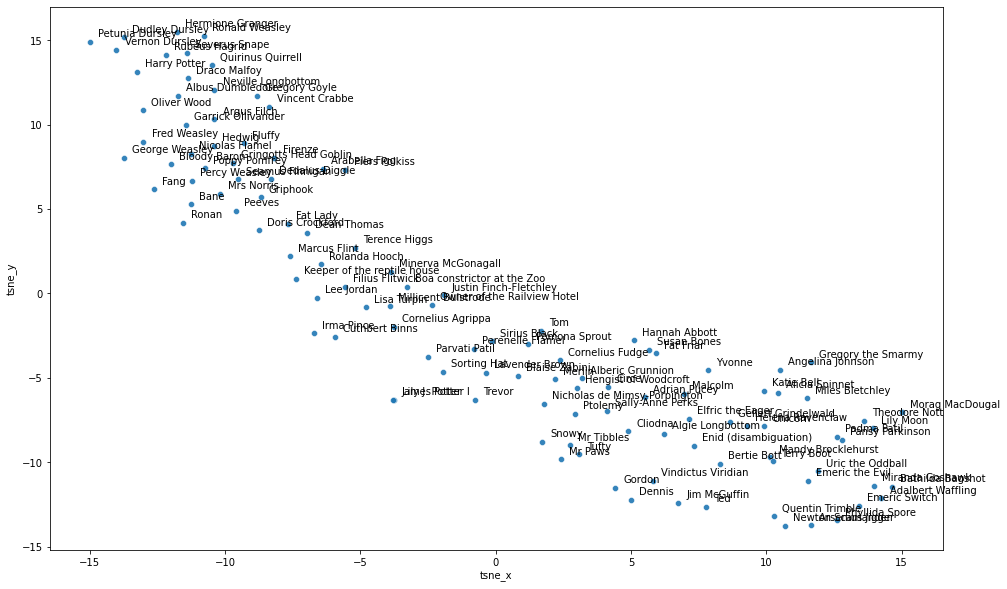

In [27]:
from karateclub.node_embedding.neighbourhood import NetMF

"""
dimensions (int): Number of embedding dimension. Default is 32.
iteration (int): Number of SVD iterations. Default is 10.
order (int): Number of PMI matrix powers. Default is 2.
negative_samples (in): Number of negative samples. Default is 1.
seed (int): SVD random seed. Default is 42.
"""

model = NetMF(dimensions=64)
model.fit(G)
embedding = model.get_embedding()

results = []
for name,embedding in zip(character_mapping['character'].to_list(), embedding):
    results.append({'character': name, 'embedding': embedding})    
df = pd.DataFrame.from_dict(results)
tsne(df)

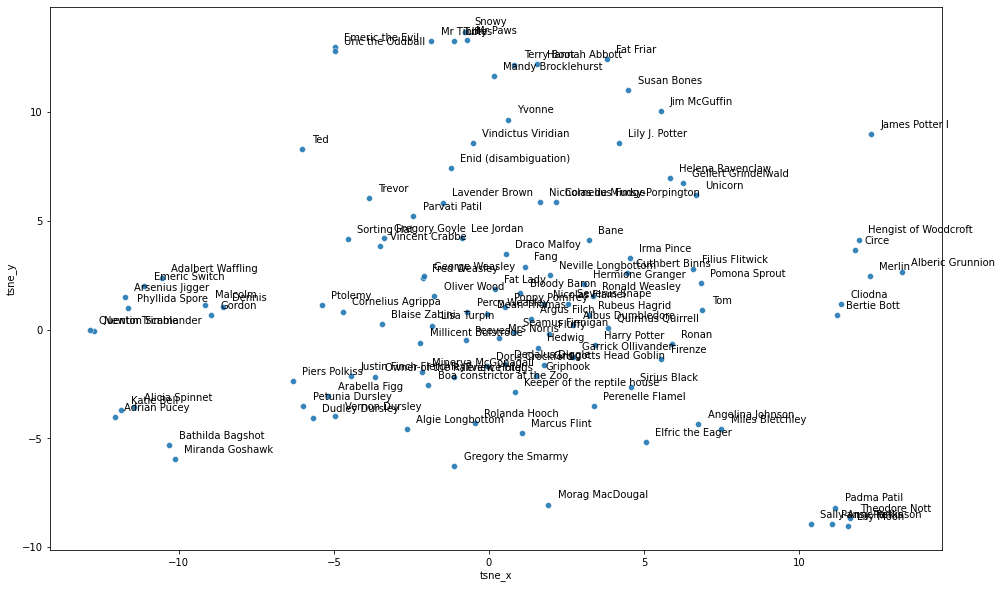

In [32]:
from karateclub.node_embedding.meta import NEU

"""
L1 (float): Weight of lower order proximities. Defauls is 0.5
L2 (float): Weight of higer order proximities. Default is 0.25.
T (int): Number of iterations. Default is 1.
seed (int): Random seed value. Default is 42.
"""

model = NetMF()
meta_model = NEU(T=3)
meta_model.fit(G, model)

embedding = meta_model.get_embedding()
results = []
for name,embedding in zip(character_mapping['character'].to_list(), embedding):
    results.append({'character': name, 'embedding': embedding})    
df = pd.DataFrame.from_dict(results)
tsne(df)

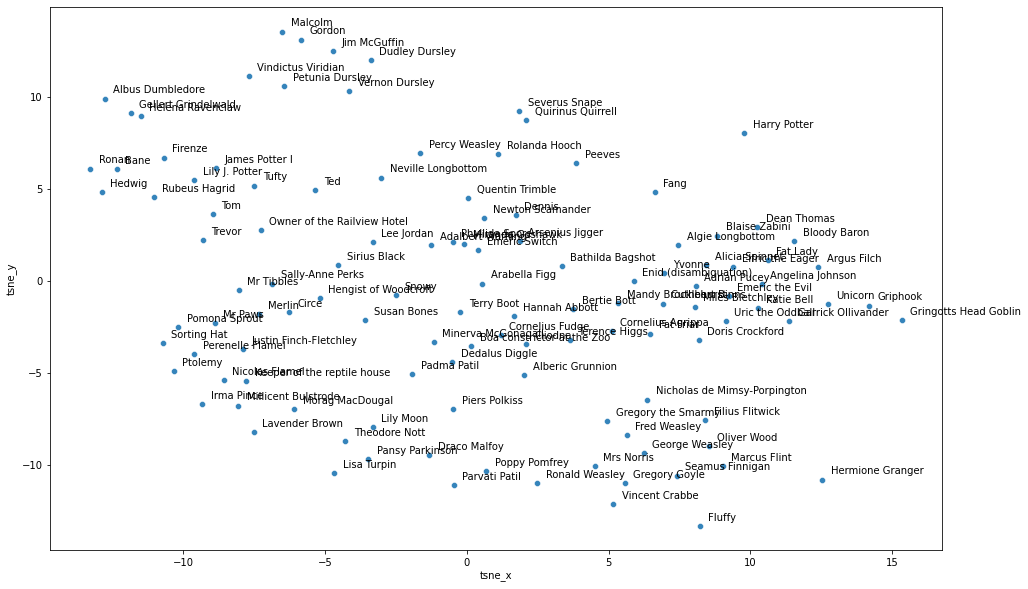

In [34]:
from karateclub.node_embedding.structural import Role2Vec

"""
walk_number (int): Number of random walks. Default is 10.
walk_length (int): Length of random walks. Default is 80.
dimensions (int): Dimensionality of embedding. Default is 128.
workers (int): Number of cores. Default is 4.
window_size (int): Matrix power order. Default is 2.
epochs (int): Number of epochs. Default is 1.
learning_rate (float): HogWild! learning rate. Default is 0.05.
down_sampling (float): Down sampling frequency. Default is 0.0001.
min_count (int): Minimal count of feature occurrences. Default is 10.
wl_iterations (int): Number of Weisfeiler-Lehman hashing iterations. Default is 2.
seed (int): Random seed value. Default is 42.
erase_base_features (bool): Removing the base features. Default is False.
"""

model = Role2Vec(walk_length=20)
model.fit(G)
embedding = model.get_embedding()

results = []
for name,embedding in zip(character_mapping['character'].to_list(), embedding):
    results.append({'character': name, 'embedding': embedding})    
df = pd.DataFrame.from_dict(results)
tsne(df)

In [48]:
df['embedding'] = [el.tolist() for el in df['embedding']]
data = list(df[['character','embedding']].T.to_dict().values())

read_query("""
UNWIND $data as row
MATCH (c:Character{name:row.character})
SET c.role2vec = row.embedding
RETURN distinct 'done'
""", {'data':data})

,'done'
0,done


In [50]:
#KNN

read_query("""
CALL gds.graph.create('role2vec', 'Character', 'INTERACTS', {nodeProperties:['role2vec']})
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Character': {'properties': {'role2vec': {'pr...,"{'INTERACTS': {'orientation': 'NATURAL', 'aggr...",role2vec,119,406,41


In [52]:
read_query("""
CALL gds.beta.knn.mutate('role2vec', {topK: 5, nodeWeightProperty:'role2vec', mutateProperty:'weight', mutateRelationshipType:'SIMILAR_ROLE'})
""")

,createMillis,computeMillis,mutateMillis,postProcessingMillis,nodesCompared,relationshipsWritten,similarityDistribution,configuration
0,0,352,218,-1,119,595,"{'p1': 0.8116912841796875, 'max': 0.9997634887...","{'topK': 5, 'maxIterations': 100, 'randomJoins..."


In [53]:
read_query("""
CALL gds.louvain.write('role2vec', {relationshipTypes:['SIMILAR_ROLE'], writeProperty:'louvain_role'})
""")

,writeMillis,nodePropertiesWritten,modularity,modularities,ranLevels,communityCount,communityDistribution,postProcessingMillis,createMillis,computeMillis,configuration
0,37,119,0.660518,"[0.6423981357248782, 0.6605183249770497]",2,5,"{'p99': 38, 'min': 6, 'max': 38, 'mean': 23.8,...",168,0,2356,"{'maxIterations': 10, 'writeConcurrency': 4, '..."


In [56]:
read_query("""
CALL gds.graph.writeRelationship('role2vec', 'SIMILAR_ROLE', 'weight')
""")

,writeMillis,graphName,relationshipType,relationshipProperty,relationshipsWritten,propertiesWritten
0,216,role2vec,SIMILAR_ROLE,weight,595,595
